<a href="https://colab.research.google.com/github/souvik25162/ArimaAnnHybrid/blob/master/Bayesian_Sarima%2Blstm_Japan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1:

#Update pymc3

In [ ]:
!pip install pymc3==3.8

In [ ]:
!pip install arviz==0.6.1

#Required Packages for Arima &Sarima

In [ ]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Japan Unempoyment dataset

In [ ]:
from google.colab import files
uploaded=files.upload()
df=pd.read_csv('japan.csv')
df.rename(columns={'japan':'values'},inplace=True)
print(df.shape)

Saving japan.csv to japan.csv
(468, 2)


In [ ]:
df.head()

,days,values
0,1,2.0
1,2,1.9
2,3,2.0
3,4,2.0
4,5,2.0


In [ ]:
df.index= pd.to_datetime(df.pop('days'))

In [ ]:
training_datalen=len(df)-36

In [ ]:
ts=df.values
train=ts[0:training_datalen]
test= ts[training_datalen:len(ts)]

In [ ]:
df.head()

,values
days,
1970-01-01 00:00:00.000000001,2.0
1970-01-01 00:00:00.000000002,1.9
1970-01-01 00:00:00.000000003,2.0
1970-01-01 00:00:00.000000004,2.0
1970-01-01 00:00:00.000000005,2.0


In [ ]:
inf=df

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r'values', lw=2)
ax.legend(loc='lower left')
plt.show()

#Basic Sarima Model with p=2 & q=1

In [67]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                           Statespace Model Results                           
Dep. Variable:                 values   No. Observations:                  468
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 358.522
Date:                Fri, 15 Jan 2021   AIC                           -711.044
Time:                        11:11:20   BIC                           -698.598
Sample:                    01-01-1970   HQIC                          -706.146
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3200.514      0.000       0.999       1.000
ma.L1         -0.1627      0.042     -3.866      0.000      -0.245      -0.080
sigma2         0.0124      0.001     17.047      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)


In [ ]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower values']
upper = predict_mle_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)
# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean[training_datalen:len(ts)].plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()


In [69]:
output= predict_mle.predicted_mean

In [70]:
pred= output[training_datalen:len(output)]

In [ ]:
pred

1970-01-01 00:00:00.000000433    3.483574
1970-01-01 00:00:00.000000434    3.413113
1970-01-01 00:00:00.000000435    3.401651
1970-01-01 00:00:00.000000436    3.399787
1970-01-01 00:00:00.000000437    3.399484
1970-01-01 00:00:00.000000438    3.315715
1970-01-01 00:00:00.000000439    3.302089
1970-01-01 00:00:00.000000440    3.216153
1970-01-01 00:00:00.000000441    3.285893
1970-01-01 00:00:00.000000442    3.129800
1970-01-01 00:00:00.000000443    3.104408
1970-01-01 00:00:00.000000444    3.183997
1970-01-01 00:00:00.000000445    3.196943
1970-01-01 00:00:00.000000446    3.115330
1970-01-01 00:00:00.000000447    3.018336
1970-01-01 00:00:00.000000448    3.002558
1970-01-01 00:00:00.000000449    2.999991
1970-01-01 00:00:00.000000450    3.167011
1970-01-01 00:00:00.000000451    2.943024
1970-01-01 00:00:00.000000452    2.990307
1970-01-01 00:00:00.000000453    2.914279
1970-01-01 00:00:00.000000454    2.985631
1970-01-01 00:00:00.000000455    2.913519
1970-01-01 00:00:00.000000456    2

In [71]:
test= ts[training_datalen:len(ts)]

In [72]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,pred)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.013888718084357078
RMSE: 0.11785040553327374


In [73]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred)
print("MAE:",error)

MAE: 0.0887947792276004


#BAYESIAN Sarima


In [ ]:
inf = df
#inf is the series we will use for analysis
print(inf.head())

                               values
days                                 
1970-01-01 00:00:00.000000001     2.0
1970-01-01 00:00:00.000000002     1.9
1970-01-01 00:00:00.000000003     2.0
1970-01-01 00:00:00.000000004     2.0
1970-01-01 00:00:00.000000005     2.0


In [ ]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)


In [ ]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

In [ ]:
# Set sampling params
ndraws = 6000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [ ]:
loglike = Loglike(mod)

In [25]:
with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -1, 1)
    maL1 = pm.Uniform('ma.L1', -1, 1)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]
Sampling chain 1, 22 divergences: 100%|██████████| 7000/7000 [03:30<00:00, 33.28it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

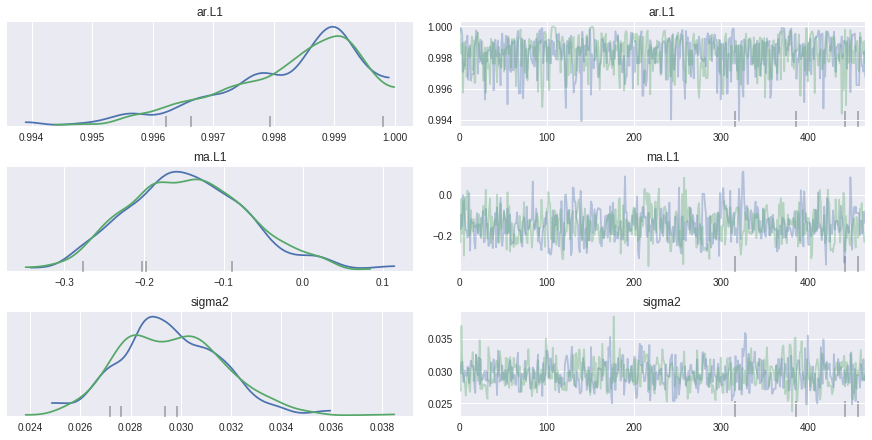

In [26]:
import arviz as az
axes = az.plot_trace(trace[0:len(ts)-1])
fig = axes.ravel()[0].figure

The NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a “block box” style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19d8a96d68>,
      dtype=object)

<Figure size 576x396 with 0 Axes>

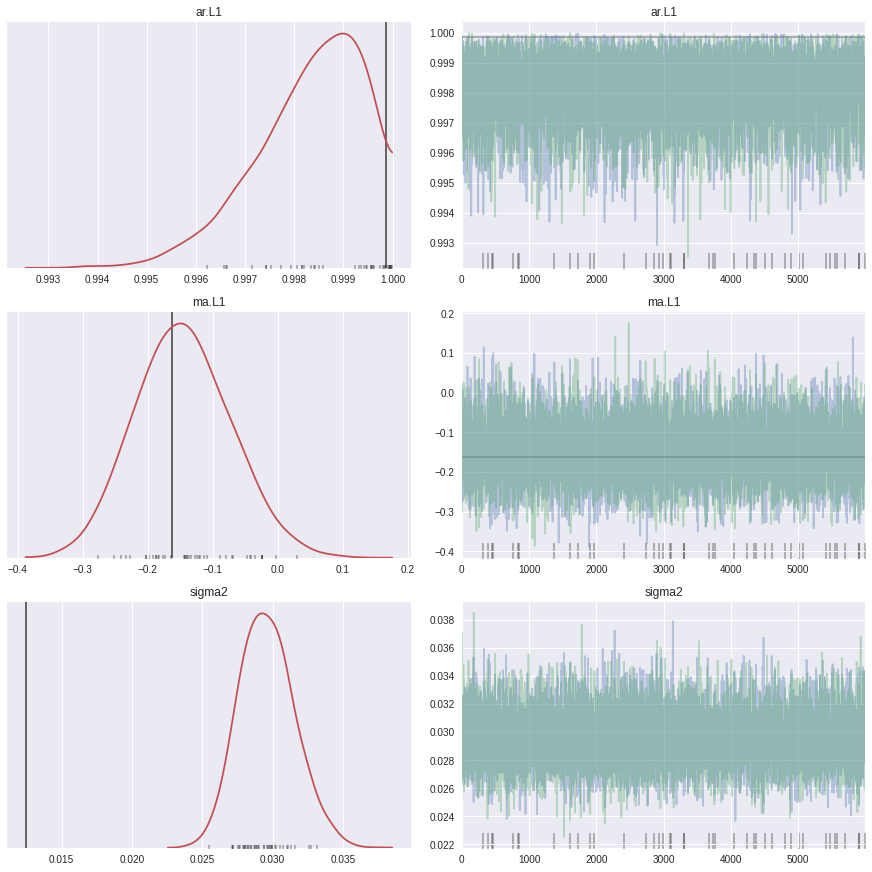

In [27]:
plt.tight_layout()
pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

In [ ]:
pm.summary(trace)

R^  is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. for all model parameters, we can have some confidence that convergence has been reached if R-hat<1.2



In [ ]:
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower values']
upper = predict_bayes_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

In [30]:
predict_bayes_output = predict_bayes.predicted_mean

In [ ]:
pred_bayes=predict_bayes_output[training_datalen:len(predict_bayes_output)]

#Rmse for bayesian model

In [ ]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

#Lstm

In [33]:
import keras
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
plt.style.use('fivethirtyeight')
import tensorflow as tf

In [34]:
data=df.filter(['values'])
dataset=data.values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [35]:
train_data= scaled_data[0:training_datalen,:]
time_step=30
test_data= scaled_data[training_datalen-time_step:,:]

In [36]:
training_datalen=len(df)-36

x_train=[]
y_train=[]
for i in range(time_step,len(train_data)):
  x_train.append(train_data[i-time_step:i,0])
  y_train.append(train_data[i,0])
  if i<=time_step:
    print(x_train)
    print(y_train)
    print()

[array([0.02564103, 0.        , 0.02564103, 0.02564103, 0.02564103,
       0.        , 0.05128205, 0.05128205, 0.05128205, 0.05128205,
       0.07692308, 0.07692308, 0.05128205, 0.1025641 , 0.07692308,
       0.1025641 , 0.12820513, 0.1025641 , 0.07692308, 0.05128205,
       0.07692308, 0.07692308, 0.07692308, 0.1025641 , 0.1025641 ,
       0.07692308, 0.1025641 , 0.1025641 , 0.12820513, 0.15384615])]
[0.1282051282051282]



In [37]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [38]:
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [39]:
print(x_train.shape)

(402, 30, 1)


In [40]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [41]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [42]:
model.fit(x_train,y_train,batch_size=10,epochs=50)

Epoch 1/50
41/41 [==============================] - 5s 24ms/step - loss: 0.0826
Epoch 2/50
41/41 [==============================] - 1s 26ms/step - loss: 0.0065
Epoch 3/50
41/41 [==============================] - 1s 26ms/step - loss: 0.0038
Epoch 4/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0033
Epoch 5/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0023
Epoch 6/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0029
Epoch 7/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0020
Epoch 8/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0017
Epoch 9/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0022
Epoch 10/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0018
Epoch 11/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0018
Epoch 12/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0023
Epoch 13/50
41/41 [==================

In [ ]:
x_test=[]
y_test= dataset[training_datalen:,:]
for i in range(time_step,len(test_data)):
  x_test.append(test_data[i-time_step:i,0])

In [ ]:
x_test=np.array(x_test)

In [ ]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
pred= model.predict(x_test)
pred1=scaler.inverse_transform(pred)

In [ ]:
train= data[:training_datalen]
valid=data[training_datalen:]
valid['pred1']=pred1

In [ ]:
plt.figure(figsize=(8,4))
plt.title("lSTM Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("unemployment rate",fontsize=18)
plt.plot(valid[['values','pred1']])
plt.legend()
plt.show()

Rmse for LSTM
(can give different results when you run the model multiple times)


In [ ]:
from sklearn.metrics import mean_squared_error
error3=mean_squared_error(test,pred1)
print("MSE:",error3)

print("RMSE:",np.sqrt(error3))

In [ ]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred1)
print("MAE:",error)

for Bayesian Sarima

In [ ]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

In [ ]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred_bayes)
print("MAE:",error)

#Hybridization(Bayesian Sarima +Lstm)

In [ ]:
NEW_PREDICTION= (pred1.T+pred_bayes.values)/2

In [ ]:
NEW_PREDICTION= np.array(NEW_PREDICTION)

In [ ]:
NEW_PREDICTION

In [56]:
pred_bayes.values

array([3.47744505, 3.40458442, 3.39387391, 3.39229946, 3.39206802,
       3.306934  , 3.2944193 , 3.20747964, 3.27979951, 3.12023053,
       3.09677389, 3.17842576, 3.19042859, 3.107093  , 3.00974267,
       2.99543217, 2.99332853, 3.16321929, 2.93289324, 2.98413531,
       2.90656789, 2.98026548, 2.90599903, 2.80998186, 2.79586733,
       2.6235925 , 2.5982681 , 2.67964541, 2.60650788, 2.34045666,
       2.55664713, 2.58842713, 2.59309879, 2.50868552, 2.58137677,
       2.59206239])

In [57]:
test.shape

(36, 1)

In [58]:
NEW_PREDICTION.shape

(1, 36)

In [59]:
pred1.shape

(36, 1)

In [60]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.01348921065432271
RMSE: 0.1161430611544345


In [61]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION.T)
print("MAE:",error)

MAE: 0.09336890296172029


#Sarima+LSTM

In [ ]:
pred1

In [ ]:
pred

In [74]:
NEW_PREDICTION2= (pred1.T+pred.values)/2

In [75]:
NEW_PREDICTION2

array([[3.48132991, 3.43995691, 3.4270756 , 3.42139918, 3.41905671,
        3.35707391, 3.33294824, 3.25994975, 3.29122598, 3.17986393,
        3.13829135, 3.17852892, 3.19406761, 3.14445137, 3.06770506,
        3.03560223, 3.01895928, 3.13153574, 2.99832735, 3.01286028,
        2.9537891 , 2.9899137 , 2.9428782 , 2.86761201, 2.83625358,
        2.70215462, 2.64685897, 2.67576219, 2.6266953 , 2.4382508 ,
        2.5355961 , 2.56426755, 2.58341431, 2.54078477, 2.58620308,
        2.60364603]])

In [76]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION2.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.013826508396436727
RMSE: 0.11758617434221051


In [77]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION2.T)
print("MAE:",error)

MAE: 0.09457432101129554
